# 3. Balloon WindField Trajectory Demo

## For Colab users:

You should **download** your ERA5 wind field data from the following link:
https://drive.google.com/file/d/1Y5ocrCH0TVf9ZDkVGaJ03ftUrtKEVxIf/view?usp=sharing

Download the data and save it into your Google Drive.

In [ ]:
## Colab users ##

# Clone the repository
!git clone https://github.com/sdean-group/balloon-outreach.git
%cd balloon-outreach
!git checkout main
!pip install -r requirements.txt

In [ ]:
## Colab users ##

import sys
sys.path.append('/content/balloon-outreach/')

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from math import cos, radians
from datetime import datetime
from env.ERA_wind_field import WindField

In [ ]:
## Colab users ##

from google.colab import drive
import gdown
import os

# 1. Mount your Drive
drive.mount('/content/drive')

# 2. Construct the full path to your file
#    e.g. if your file is in the top-level of My Drive:
path = '/content/drive/My Drive/era5_data.nc'

# 3. Check existence
if os.path.exists(path):
    print("✅ Found:", path)
    datapath = '/content/drive/My Drive/era5_data.nc'
else:
    print("❌ Not found:", path)
    # Download ERA5 data
    file_id = "1Y5ocrCH0TVf9ZDkVGaJ03ftUrtKEVxIf"
    url = f"https://drive.google.com/uc?id={file_id}"
    output = "era5_data.nc"
    gdown.download(url, output, quiet=False)
    datapath = "/content/balloon-outreach/era5_data.nc"


## Balloon Trajectory with WindField

In [2]:
ds = xr.open_dataset(datapath, engine='netcdf4')

In [3]:
# Simulation parameters
dt = 60  # Time step in seconds
num_steps = 240  # Number of time steps to simulate (simulation time = dt * num_steps)

# Ithaca, NY
initial_lat = 42.6  # Initial latitude (degrees)
initial_lon = -76.50  # Initial longitude (degrees)
initial_alt = 10  # Initial altitude (km)
# Initial resources
# Balloon will drop if resources are not used.
initial_volume = 1000.0  # Initial volume (m³)
initial_sand = 100  # Initial sand mass (kg)
# Balloon will go up, burst and drop if resources are not used.
# initial_volume = 1000.0  # Initial volume (m³)
# initial_sand = 90.0  # Initial sand mass (kg)
print("Simulation Parameters:")
print(f"Time step (dt): {dt} seconds")
print(f"Initial position: ({initial_lat}°, {initial_lon}°)")
print(f"Initial altitude: {initial_alt} km")
print(f"Initial volume: {initial_volume} m³")
print(f"Initial sand: {initial_sand} kg")

# Create balloon instance
balloon = Balloon(
    initial_lat=initial_lat,
    initial_lon=initial_lon,
    initial_alt=initial_alt,
    initial_volume=initial_volume,
    initial_sand=initial_sand
)
initial_helium = balloon.helium_mass

print("\nBalloon created successfully!")
print(f"Initial helium mass: {balloon.helium_mass:.2f} kg")
print(f"Max volume (burst limit): {balloon.max_volume} m³")

Simulation Parameters:
Time step (dt): 60 seconds
Initial position: (42.6°, -76.5°)
Initial altitude: 10 km
Initial volume: 1000.0 m³
Initial sand: 100 kg

Balloon created successfully!
Initial helium mass: 178.60 kg
Max volume (burst limit): 2500.0 m³


In [4]:
def altitude_profile(step):
    return initial_alt + 3 * np.sin(step*3/num_steps * 2 * np.pi)

start_time = pd.to_datetime(ds.valid_time.values[0]).to_pydatetime()
wf = WindField(ds, start_time=start_time, add_noise=False)

WindField initialized with noise enabled: False


In [5]:
times = np.arange(0, num_steps * dt, dt)
altitudes = []
latitudes = []
longitudes = []
volumes = []
helium_masses = []
sand_masses = []
forces = []
print(f"Running simulation for {num_steps} steps with dt={dt}s...")
print(f"Total simulation time: {num_steps * dt} seconds ({num_steps * dt / 3600:.2f} hours)")

# Store initial state
altitudes.append(balloon.alt)
latitudes.append(balloon.lat)
longitudes.append(balloon.lon)
volumes.append(balloon.volume)
helium_masses.append(balloon.helium_mass)
sand_masses.append(balloon.sand)
forces.append(balloon.forces)
burst_flag = False
depletion_flag = False
# Run simulation
for step in range(num_steps):
    # Control the balloon's altitude with velocity
    plev = balloon.altitude_to_pressure(balloon.alt*1000)
    elapsed_h = (step * dt) / 3600.0
    wind = wf.get_wind(balloon.lon, balloon.lat, plev, elapsed_h)
    if burst_flag == False and depletion_flag == False:
        result = balloon.step_with_altitude(wind, dt, target_altitude=altitude_profile(step))
    # Unable to control balloon due to emergency
    else:
        result = balloon.step_with_resource(dt, dHelium, dSand, wind)
    # result = balloon.step_with_resource(dt, dHelium, dSand, wind)
    
    # Check if simulation ended due to resource depletion
    if result is not None:  # Resource depletion message
        if result == f"Balloon Crashed":
            print(f"\nSimulation stopped at step {step + 1}: {result}")
            break
        elif result == f"Balloon burst : {balloon.volume}":
            if burst_flag == False:
                print(f"\nAt step {step + 1}: {result}")
                burst_flag = True
                dHelium = initial_helium * 0.1 # start descend untrollably
                dSand = 0.0
        else:
            if depletion_flag == False:
                print(f"\nAt step {step + 1}: {result}")
                dHelium = 0.0
                dSand = 0.0
                depletion_flag = True
        
    altitudes.append(balloon.alt)
    latitudes.append(balloon.lat)
    longitudes.append(balloon.lon)
    volumes.append(balloon.volume)
    helium_masses.append(balloon.helium_mass)
    sand_masses.append(balloon.sand)
    forces.append(balloon.forces)
    
    # Progress indicator
    if (step + 1) % 20 == 0:
        print(f"Completed step {step + 1}/{num_steps}")

print("\nSimulation completed!")
print(f"Final altitude: {balloon.alt:.3f} km")
print(f"Final position: ({balloon.lat:.6f}°, {balloon.lon:.6f}°)")
print(f"Final volume: {balloon.volume:.2f} m³")
print(f"Remaining helium: {balloon.helium_mass:.2f} kg")
print(f"Remaining sand: {balloon.sand:.2f} kg")

Running simulation for 240 steps with dt=60s...
Total simulation time: 14400 seconds (4.00 hours)
Completed step 20/240
Completed step 40/240
Completed step 60/240
Completed step 80/240
Completed step 100/240
Completed step 120/240
Completed step 140/240
Completed step 160/240
Completed step 180/240
Completed step 200/240
Completed step 220/240
Completed step 240/240

Simulation completed!
Final altitude: 9.455 km
Final position: (51.455520°, -76.984734°)
Final volume: 861.18 m³
Remaining helium: 168.06 kg
Remaining sand: 85.78 kg


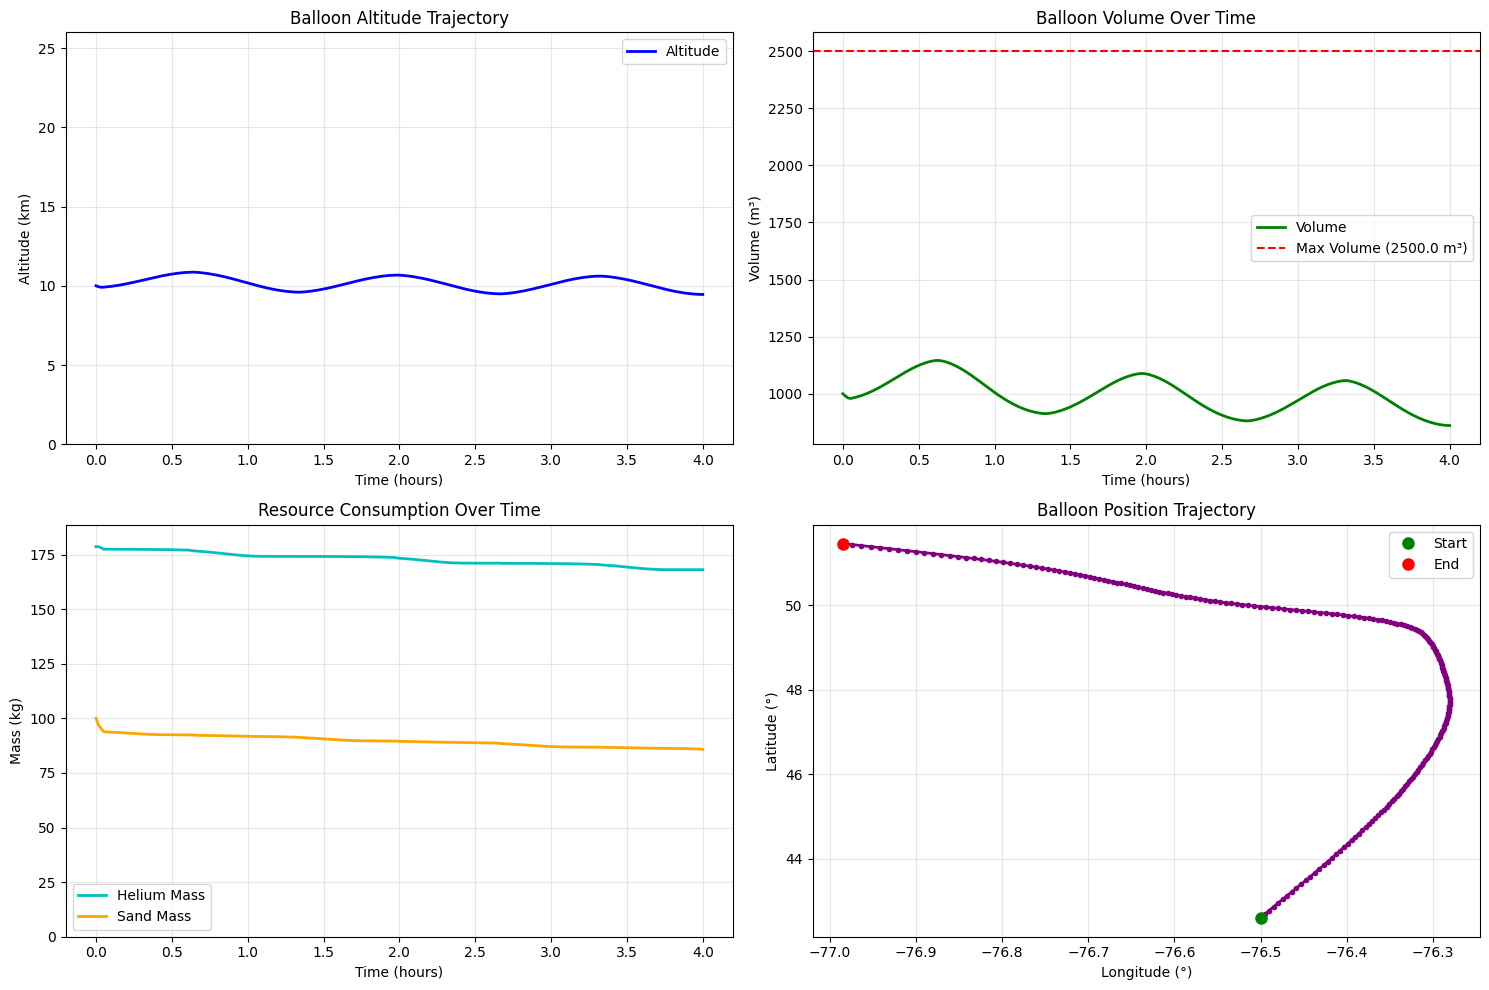

In [8]:
from env.visualize import BalloonSummaryPlotter
plotter = BalloonSummaryPlotter(
    altitudes, volumes, helium_masses, sand_masses,
    longitudes, latitudes, dt, balloon
)
plotter.plot()

/opt/anaconda3/envs/balloon-outreach/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/opt/anaconda3/envs/balloon-outreach/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/opt/anaconda3/envs/balloon-outreach/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


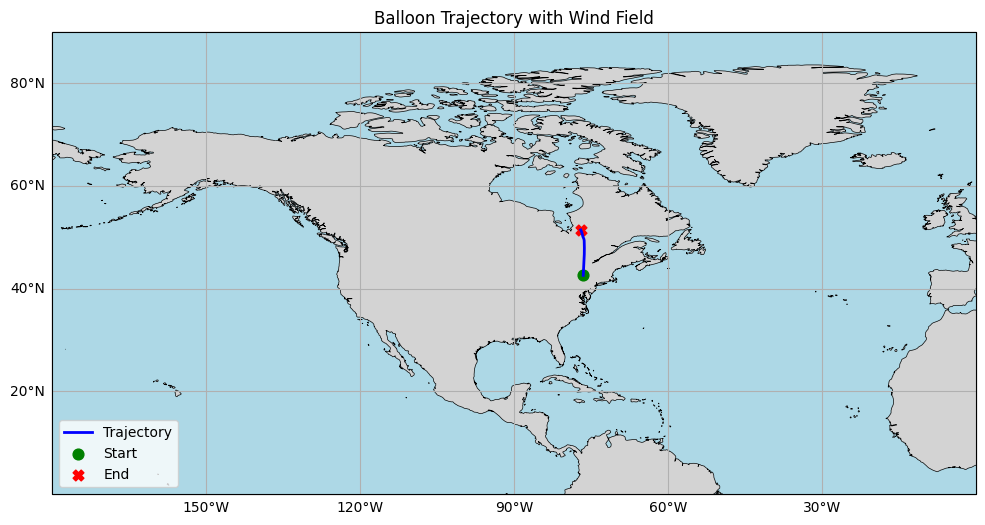

In [ ]:
from env.visualize import plot_trajectory_map
plot_trajectory_map(longitudes, latitudes)

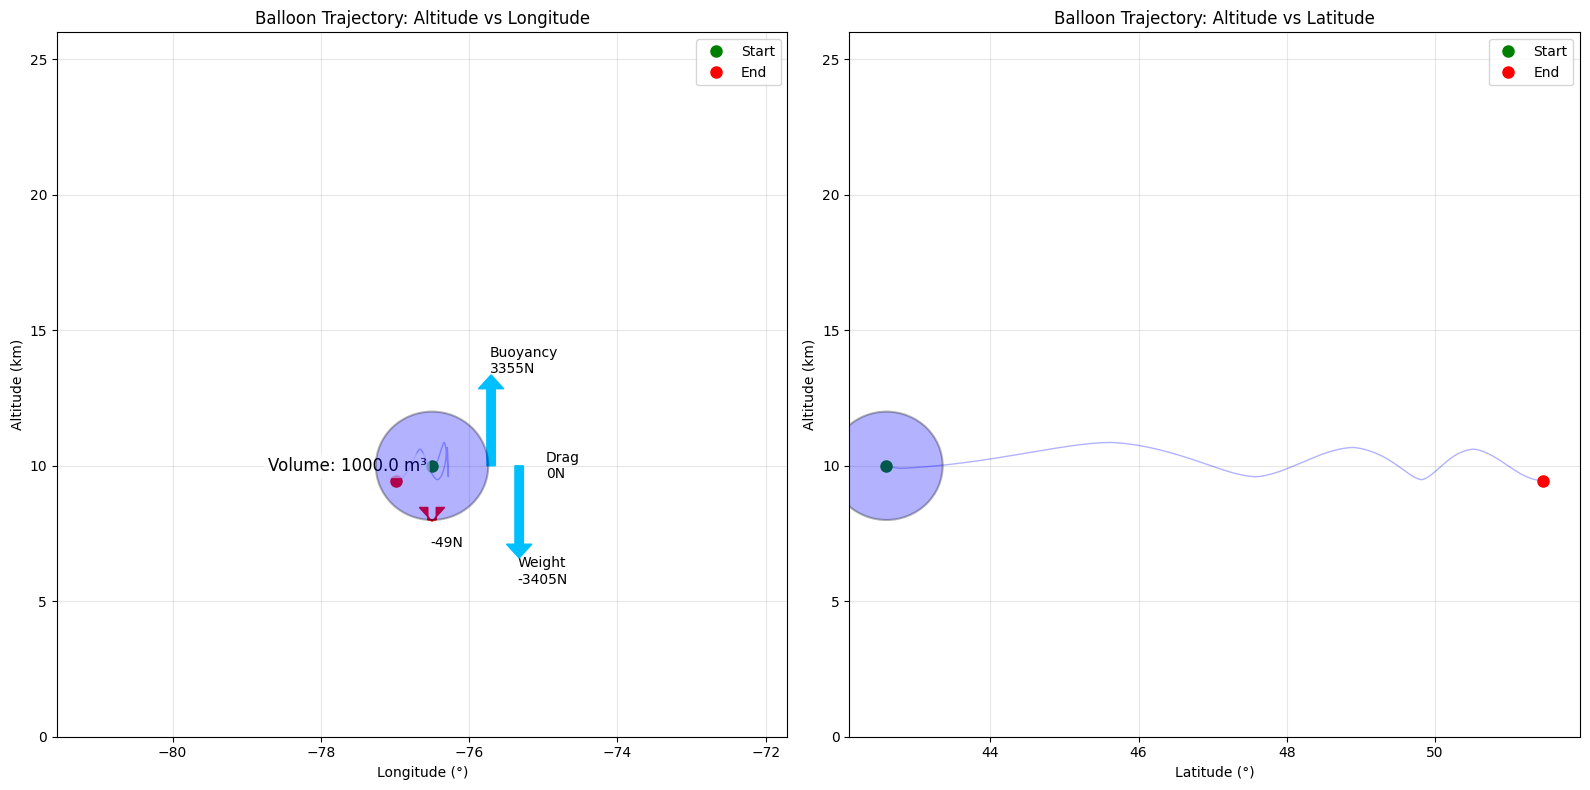

In [10]:
from env.visualize import BalloonTrajectoryAnimator
animator = BalloonTrajectoryAnimator(longitudes, latitudes, altitudes, volumes, forces)
animator.animate()
animator.save('trajectory_altitude_control.mp4')